In [1]:
import torch
import torch.nn as nn
from data_sample import generate_example_data as data
from matplotlib import pyplot as plt
import GP_CommonCalculation as GP
import kernel
from kernel import RBFKernel, LinearKernel, RationalQuadraticKernel, PeriodicKernel
import torch.optim as optim
import importlib

# I use torch (1.11.0) for this work. lower version may not work.
from cigp_v10 import cigp
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True' # Fixing strange error if run in MacOS
JITTER = 1e-6
EPS = 1e-10
PI = 3.1415

2.2.1


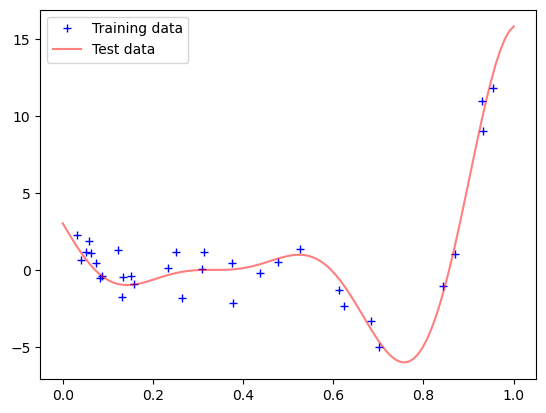

In [2]:
# generate example data
xtr, ytr,xte,yte = data.generate(32,100,seed=42)
data.plot(xtr, ytr,xte,yte)

In [66]:
class neural_kernel(nn.Module):
    def __init__(self, x_dim, num_kernels=3,dtype=torch.float64,EPS=1e-6):
        """
        Initializes the neural_kernel class.

        Parameters:
        - x_dim (int): The number of dimensions (features) in the input data. This is used for ARD in the kernels.
        - num_kernels (int): The number of different kernels whose outputs will be combined. Default is 3.
        """
        super(neural_kernel, self).__init__()
        self.RBFKernel_1 = RBFKernel(x_dim)
        self.RQKern_1 = RationalQuadraticKernel(x_dim)
        self.PerKern_1 = PeriodicKernel(x_dim)
        self.linear_1 = nn.Linear(num_kernels, 1,dtype=dtype)
        nn.init.uniform_(self.linear_1.weight, a=0.5 * 1. / (2 * self.linear_1.in_features),
                         b=0.5 * 3. / (2 * self.linear_1.in_features))
        self.EPS = EPS

    def forward(self, x1, x2):
        """
        Forward pass through the neural kernel network.

        Parameters:
        - x1 (Tensor): The first input tensor.
        - x2 (Tensor): The second input tensor.

        Returns:
        - var_act (Tensor): The output tensor after applying the kernels, linear layer, and activation function.
        """
        var1 = self.RBFKernel_1.forward(x1, x2)
        var2 = self.PerKern_1.forward(x1, x2)
        var3 = self.RQKern_1.forward(x1, x2)
        var = torch.stack((var1, var2, var3), dim=-1)  # Stack along a new dimension (third dimension)
        var_lin1 = self.linear_1(var).reshape(var1.shape)
        return var_lin1.abs()+self.EPS

In [76]:
x_dim= xtr.size(1)
kernel= neural_kernel(x_dim)

In [77]:
#initiate_log_beta
log_beta = nn.Parameter(torch.ones(1) * -4) # this is a large noise. we optimize to shrink it to a proper value.

In [78]:
def negative_log_likelihood(xtr, ytr, kernel,log_beta):
    Sigma = kernel(xtr, xtr) + log_beta.exp().pow(-1) * torch.eye(
        xtr.size(0)) + JITTER * torch.eye(xtr.size(0))
    return -GP.Gaussian_log_likelihood(ytr, Sigma)


In [79]:
def forward(xtr, ytr, xte, kernel,log_beta):
    n_test = xte.size(0)
    #xte=data_normalizer.normalize(xte)
    Sigma = kernel(xtr, xtr) + log_beta.exp().pow(-1) * torch.eye(
        xtr.size(0)) + JITTER * torch.eye(xtr.size(0))

    K_s = kernel(xtr, xte)
    K_ss= kernel(xte, xte)

    mean, var = GP.conditional_Gaussian(ytr, Sigma, K_s, K_ss)

    var_diag = var.sum(dim=0).view(-1, 1)
    var_diag = var_diag + log_beta.exp().pow(-1)

    # Denormalize
    #mean, var_diag = data_normalizer.denormalize_result(mean, var_diag)
    return mean, var_diag

In [80]:
def train_adam(xtr, ytr, kernel, log_beta, niteration=10, lr=0.1):
    # Adam optimizer
    optimizer = optim.Adam([
        {'params': kernel.parameters()},
        {'params': [log_beta]}
    ], lr=lr)

    for i in range(niteration):
        optimizer.zero_grad()
        loss = negative_log_likelihood(xtr, ytr, kernel, log_beta)
        loss.backward()
        optimizer.step()

        # Print kernel parameters
        #for name, param in kernel.named_parameters():
            #if param.requires_grad:
                #print(f'{name}: {param.data}')

        #print('log_beta:', log_beta.data)
        if i % 10 == 0:
            print('iter', i, 'nll:{:.5f}'.format(loss.item()))

In [81]:
train_adam(xtr, ytr, kernel, log_beta, niteration=400,lr=0.03)

iter 0 nll:97.26187
iter 10 nll:93.79057
iter 20 nll:90.88182
iter 30 nll:88.57404
iter 40 nll:86.73931
iter 50 nll:85.30034
iter 60 nll:84.22577
iter 70 nll:83.38669
iter 80 nll:82.79447
iter 90 nll:82.37367
iter 100 nll:82.10181
iter 110 nll:81.89511
iter 120 nll:81.75954
iter 130 nll:81.65981
iter 140 nll:81.58545
iter 150 nll:81.56193
iter 160 nll:81.13234
iter 170 nll:77.68457
iter 180 nll:73.49731
iter 190 nll:70.09784
iter 200 nll:67.02385
iter 210 nll:69.92634
iter 220 nll:67.21576
iter 230 nll:64.85442
iter 240 nll:64.20550
iter 250 nll:64.09090
iter 260 nll:64.05005
iter 270 nll:64.01907
iter 280 nll:63.99943
iter 290 nll:63.98901
iter 300 nll:63.98263
iter 310 nll:63.97749
iter 320 nll:63.97276
iter 330 nll:63.96832
iter 340 nll:63.96419
iter 350 nll:63.96032
iter 360 nll:63.95666
iter 370 nll:63.95319
iter 380 nll:63.94987
iter 390 nll:63.94670


In [82]:
with torch.no_grad():
    ypred, yvar = forward(xtr, ytr, xte, kernel,log_beta)

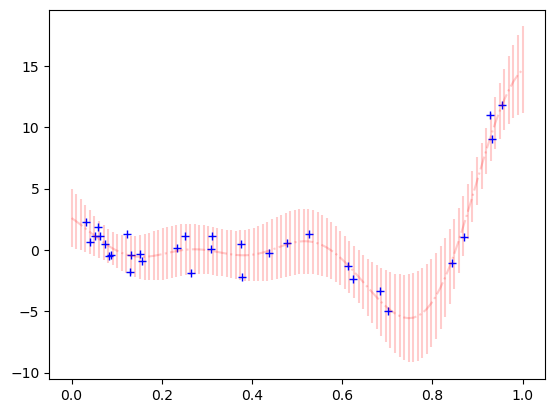

In [83]:
#xtr,ytr=data_normalizer.denormalize(xtr,ytr)
plt.errorbar(xte.numpy().reshape(100), ypred.detach().numpy().reshape(100),
             yerr=yvar.sqrt().squeeze().detach().numpy(), fmt='r-.', alpha=0.2)
plt.plot(xtr.numpy(), ytr.numpy(), 'b+')
plt.show()

In [84]:
#Comparing with standard GP
model2=cigp(xtr, ytr)
model2.train_adam(100,0.1)
with torch.no_grad():
    ypred2, yvar2 = model2.forward(xte)
mse_neuralKernel = ((yte - ypred) ** 2).mean()
mse_standardGP = ((yte - ypred2) ** 2).mean()
print('mse_neuralKernel:',mse_neuralKernel)
print('mse_standardGP:',mse_standardGP)

iter 0 nll:42.66771
iter 10 nll:31.22810
iter 20 nll:24.20384
iter 30 nll:23.08859
iter 40 nll:23.10083
iter 50 nll:22.75421
iter 60 nll:22.79893
iter 70 nll:22.74644
iter 80 nll:22.75299
iter 90 nll:22.74604
mse_neuralKernel: tensor(0.2561, dtype=torch.float64)
mse_standardGP: tensor(0.2392, dtype=torch.float64)
